# 🔬 [10] Load WLASL for SLT

- **Experiment No**: 10
- **Author**: Huynh Nhan Thap (21521457@gm.uit.edu.vn)
- **Course**: Computer Science 406: Image Processing and Applications
- **Date**: 2024-12-12

<!-- ## Description -->

## Results

Generated [wlasl_mapping.json](../assets//wlasl_mapping.json) that maps dictionary video file names to corresponding text language words.

<!-- ## Discussion -->

## Code

In [1]:
import json
import os
from typing import Literal, Union

import cv2
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from tqdm import tqdm

import torch

import sign_language_translator as slt
from utils import get_torch_device, flush

from IPython.display import Video

In [2]:
device = get_torch_device(verbose=True)
flush()

[Device]: "cuda"
[Device name]: NVIDIA GeForce RTX 3050 Laptop GPU
Garbage collector flushed 38 objects


In [3]:
def read_video(filename: str) -> np.ndarray:
    cap = cv2.VideoCapture(filename)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)


def show_image(image: Union[str, np.ndarray]) -> None:
    if isinstance(image, str):
        image = cv2.imread(image)
    assert isinstance(image, np.ndarray), 'Invalid image format'
    plt.imshow(image[..., ::-1])
    plt.show()

### Pre-downloaded WLASL1000 dataset

In [ ]:
wlasl_path = r'd:\temp\cloned\word_level_slr\third_party\WLASL\start_kit'

assert os.path.isdir(wlasl_path)

def wlasl_video_path(video_id: int, *, checks_exist=True) -> str:
    path = os.path.join(wlasl_path, 'videos', f'{video_id}.mp4')
    if checks_exist:
        assert os.path.exists(path), f'Video not found: {path}'
    return path

flush()

wlasl_path

Garbage collector flushed 0 objects


'd:\\temp\\cloned\\word_level_slr\\third_party\\WLASL\\start_kit'

In [5]:
with open(os.path.join(wlasl_path, 'WLASL_v0.3.1000.json'), 'rt') as f:
    metadata = json.loads(f.read())
    
flush()
len(metadata)

Garbage collector flushed 0 objects


1000

In [6]:
i = 2

print('Gloss %d: "%s"' % (i, metadata[i]['gloss']))
print('Instance count: %d' % (len(metadata[i]['instances'])))
print('First video:')

metadata[i]['instances'][0]

Gloss 2: "computer"
Instance count: 30
First video:


{'bbox': [0, 0, 360, 240],
 'fps': 25,
 'frame_end': 5181,
 'frame_start': 5122,
 'instance_id': 0,
 'signer_id': 9,
 'source': 'asl5200',
 'split': 'test',
 'url': 'https://www.youtube.com/watch?v=PPmQd2zWdP0',
 'variation_id': 0,
 'video_id': '12306'}

Garbage collector flushed 0 objects
..\..\word_level_slr\third_party\WLASL\start_kit\videos\12306.mp4


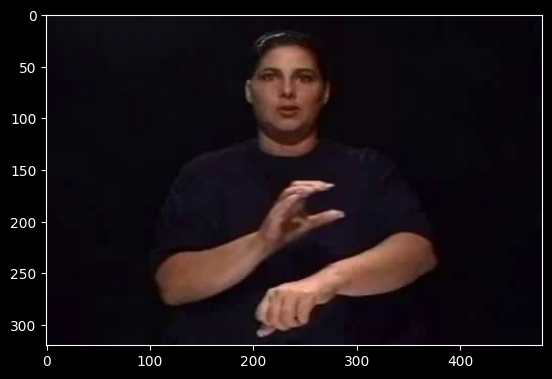

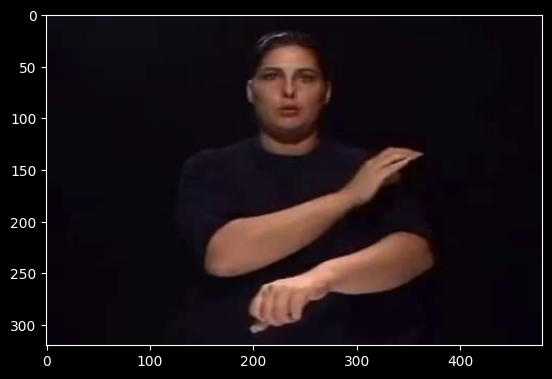

(dtype('uint8'), (60, 320, 480, 3))

In [7]:
flush()
video_id = metadata[i]['instances'][0]['video_id']
video_path = wlasl_video_path(video_id)
video_path = os.path.relpath(video_path)
print(video_path)
video = read_video(video_path)
show_image(video[0])
show_image(video[-1])
video.dtype, video.shape

### Prepare JSON file for SLT

In [8]:
mapping = dict() # word-to-video_id
for gloss in tqdm(metadata):
    word = gloss['gloss']
    videos = gloss['instances']
    for video in videos:
        video_id = video['video_id']
        video_path = wlasl_video_path(video_id, checks_exist=False)
        if os.path.exists(video_path):
            if word not in mapping:
                mapping[word] = set()
            mapping[word].add(video_id)

video_count = sum(map(lambda item: len(item[1]), mapping.items()))
print('Word count: %d' % len(mapping))
print('Total video count: %d' % video_count)
print('Average video count per word: %.2f' % (video_count / len(mapping)))
print('First word and its videos:')
for i, (word, video_ids) in enumerate(mapping.items()):
    print('❄️', word, '(%d videos)' % len(video_ids), video_ids)
    if i == 5: break

100%|██████████| 1000/1000 [00:00<00:00, 1431.09it/s]

Word count: 1000
Total video count: 8616
Average video count per word: 8.62
First word and its videos:
❄️ book (11 videos) {'68012', '07069', '07074', '07076', '70266', '70212', '07068', '69241', '07070', '07075', '68011'}
❄️ drink (20 videos) {'17723', '68041', '17731', '17724', '17720', '17711', '17725', '17722', '69302', '17710', '17728', '17713', '17729', '70173', '65540', '17730', '17721', '17709', '68042', '17712'}
❄️ computer (20 videos) {'68028', '12327', '12331', '12319', '12315', '12328', '12306', '12335', '12316', '12313', '12326', '12311', '12330', '12329', '12320', '12333', '12318', '12314', '12317', '12312'}
❄️ before (19 videos) {'70348', '05747', '05728', '05734', '05729', '05742', '05727', '05732', '68007', '05739', '05743', '05730', '05733', '05724', '05731', '05746', '05744', '05741', '05740'}
❄️ chair (11 videos) {'09851', '65328', '09854', '09847', '09855', '70263', '09850', '70230', '09849', '68019', '09848'}
❄️ go (17 videos) {'24946', '24857', '24952', '24941', 

```json
[
    {
        "country": "us",
        "description": "",
        "mapping": [
            {
                "component": ["video_1", "video_2"],
                "token": {
                    "en": ["meaning"],
                }
            },
            {
                "component": ["video_1", "video_2"],
                "token": {
                    "en": ["meaning"],
                }
            }
        ],
        "organization": "wlasl",
        "url": "",
    }
]
```

In [9]:
def make_mapping_item(item):
    word, video_ids = item
    return {
        "component": list(video_ids),
        "token": { "en": [word] },
    }

dictionary = [
    {
        "country": "us",
        "description": "",
        "mapping": list(map(make_mapping_item, mapping.items())),
        "organization": "wlasl",
        "url": "",
    },
]

with open('wlasl_mapping.json', 'w', encoding='utf-8') as f:
    json.dump(dictionary, f, indent=2, ensure_ascii=False)

flush()

Garbage collector flushed 3351 objects
